## Enron Data set project.
#### Building a Machine Learning model to identify Persons of Interest from the Enron scandal

### Project details

The features in the data fall into three major types, namely financial features, email features and POI labels.

- financial features: ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees'] (all units are in US dollars)
- email features: ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi'] (units are generally number of emails messages; notable exception is ‘email_address’, which is a text string)
- POI label: `poi` (boolean, represented as integer)

In [2]:
#!/usr/bin/python

import sys
import pickle
import os
sys.path.append(os.path.abspath(("../tools/")))


In [3]:
# %pip install matplotlib
# %pip install seaborn

In [4]:
# Data wrangling imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

##### Helper Functions


In [5]:
def featureFormat( dictionary, features, remove_NaN=True, remove_all_zeroes=True, remove_any_zeroes=False, sort_keys = False):
    """ convert dictionary to numpy array of features
        remove_NaN = True will convert "NaN" string to 0.0
        remove_all_zeroes = True will omit any data points for which
            all the features you seek are 0.0
        remove_any_zeroes = True will omit any data points for which
            any of the features you seek are 0.0
        sort_keys = True sorts keys by alphabetical order. Setting the value as
            a string opens the corresponding pickle file with a preset key
            order (this is used for Python 3 compatibility, and sort_keys
            should be left as False for the course mini-projects).
        NOTE: first feature is assumed to be 'poi' and is not checked for
            removal for zero or missing values.
    """


    return_list = []

    # Key order - first branch is for Python 3 compatibility on mini-projects,
    # second branch is for compatibility on final project.
    if isinstance(sort_keys, str):
        import joblib
        keys = joblib.load(open(sort_keys, "rb"))
    elif sort_keys:
        keys = sorted(dictionary.keys())
    else:
        keys = dictionary.keys()

    for key in keys:
        tmp_list = []
        for feature in features:
            try:
                dictionary[key][feature]
            except KeyError:
                print("Error: Key ", feature, " Not Present")
                return
            value = dictionary[key][feature]
            if value == "NaN" and remove_NaN:
                value = 0
            tmp_list.append( float(value) )

        # Logic for deciding whether or not to add the data point.
        append = True
        # exclude 'poi' class as criteria.
        if features[0] == 'poi':
            test_list = tmp_list[1:]
        else:
            test_list = tmp_list
        ### if all features are zero and you want to remove
        ### data points that are all zero, do that here
        if remove_all_zeroes:
            append = False
            for item in test_list:
                if item != 0 and item != "NaN":
                    append = True
                    break
        ### if any features for a given data point are zero
        ### and you want to remove data points with any zeroes,
        ### handle that here
        if remove_any_zeroes:
            if 0 in test_list or "NaN" in test_list:
                append = False
        ### Append the data point if flagged for addition.
        if append:
            return_list.append( np.array(tmp_list) )

    return np.array(return_list)


In [6]:
def targetFeatureSplit( data ):
    """ 
        given a numpy array like the one returned from
        featureFormat, separate out the first feature
        and put it into its own list (this should be the 
        quantity you want to predict)

        return targets and features as separate lists

        (sklearn can generally handle both lists and numpy arrays as 
        input formats when training/predicting)
    """

    target = []
    features = []
    for item in data:
        target.append( item[0] )
        features.append( item[1:] )

    return target, features

### Task 1: Select what features you'll use.
> features_list is a list of strings, each of which is a feature name.
> The first feature must be "poi".

In [7]:
features_list = ['poi','salary', 'bonus', 'from_poi_to_this_person', 'from_this_person_to_poi' ] # You will need to use more features

> Load the dictionary containing the dataset

In [8]:
with open("enron_data.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)

### Task 2: Remove outliers

In [9]:
df = data_dict

In [10]:
df = pd.DataFrame(df)
df.head(4)

,METTS MARK,BAXTER JOHN C,ELLIOTT STEVEN,CORDES WILLIAM R,HANNON KEVIN P,MORDAUNT KRISTINA M,MEYER ROCKFORD G,MCMAHON JEFFREY,HAEDICKE MARK E,PIPER GREGORY F,...,SAVAGE FRANK,IZZO LAWRENCE L,TILNEY ELIZABETH A,MARTIN AMANDA K,BUY RICHARD B,GRAMM WENDY L,CAUSEY RICHARD A,TAYLOR MITCHELL S,DONAHUE JR JEFFREY M,GLISAN JR BEN F
salary,365788,267102,170941,NaN,243293,267093,NaN,370448,374125,197091,...,NaN,85274,247338,349487,330546,NaN,415189,265214,278601,274975
to_messages,807,NaN,NaN,764,1045,NaN,232,2355,4009,1238,...,NaN,496,460,1522,3523,NaN,1892,533,865,873
deferral_payments,NaN,1295738,NaN,NaN,NaN,NaN,1848227,NaN,2157527,1130036,...,NaN,NaN,NaN,85430,649584,NaN,NaN,227449,NaN,NaN
total_payments,1061827,5634343,211725,NaN,288682,628522,1848227,4099771,3859065,1737629,...,3750,1979596,399393,8407016,2355702,119292,1868758,1092663,875760,1272284


In [11]:
df_t = df.T
df_t.columns

Index(['salary', 'to_messages', 'deferral_payments', 'total_payments',
       'loan_advances', 'bonus', 'email_address', 'restricted_stock_deferred',
       'deferred_income', 'total_stock_value', 'expenses',
       'from_poi_to_this_person', 'exercised_stock_options', 'from_messages',
       'other', 'from_this_person_to_poi', 'poi', 'long_term_incentive',
       'shared_receipt_with_poi', 'restricted_stock', 'director_fees'],
      dtype='object')

In [12]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
Index: 143 entries, METTS MARK to GLISAN JR BEN F
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   salary                     143 non-null    object
 1   to_messages                143 non-null    object
 2   deferral_payments          143 non-null    object
 3   total_payments             143 non-null    object
 4   loan_advances              143 non-null    object
 5   bonus                      143 non-null    object
 6   email_address              143 non-null    object
 7   restricted_stock_deferred  143 non-null    object
 8   deferred_income            143 non-null    object
 9   total_stock_value          142 non-null    object
 10  expenses                   143 non-null    object
 11  from_poi_to_this_person    143 non-null    object
 12  exercised_stock_options    143 non-null    object
 13  from_messages              143 non-null    object

<hr/>


### Clean the data
#### convert features to int 

In [13]:
# convert salary to int  
df_t.salary = df_t.salary.apply(lambda x: int(x) if x != 'NaN' else np.nan)
df_t.from_poi_to_this_person = df_t.from_poi_to_this_person.apply(lambda x: int(x) if x != 'NaN' else np.nan)
df_t.from_this_person_to_poi = df_t.from_this_person_to_poi.apply(lambda x: int(x) if x != 'NaN' else np.nan)
df_t.bonus = df_t.bonus.apply(lambda x: int(x) if x != 'NaN' else np.nan)

#### Find outliers from the salary feature

In [14]:
df_t.salary.describe()

count    9.200000e+01
mean     2.665288e+05
std      1.319352e+05
min      4.770000e+02
25%      2.115140e+05
50%      2.545700e+05
75%      3.042295e+05
max      1.060932e+06
Name: salary, dtype: float64

In [15]:
df_t.isnull().sum()

salary                       51
to_messages                   0
deferral_payments             0
total_payments                0
loan_advances                 0
bonus                        64
email_address                 0
restricted_stock_deferred     0
deferred_income               0
total_stock_value             1
expenses                      0
from_poi_to_this_person      59
exercised_stock_options       0
from_messages                 0
other                         0
from_this_person_to_poi      59
poi                           0
long_term_incentive           0
shared_receipt_with_poi       0
restricted_stock              0
director_fees                 0
dtype: int64

In [16]:
np.log10(df_t.salary).describe()

count    92.000000
mean      5.350078
std       0.374550
min       2.678518
25%       5.325338
50%       5.405779
75%       5.483201
max       6.025688
Name: salary, dtype: float64

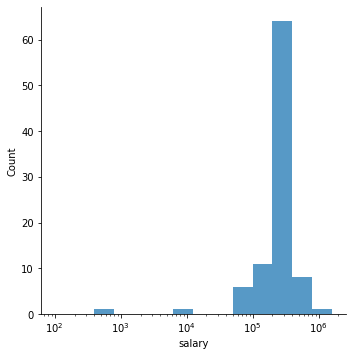

In [17]:
#A scaled hist plot to see the salary distribution
bins = 10** np.arange(2, np.log10(df_t.salary).max() + 0.3, 0.3)
sns.displot(df_t.salary, bins = bins)
plt.xscale('log')

/Users/joshiverse/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.0, 1200000.0)

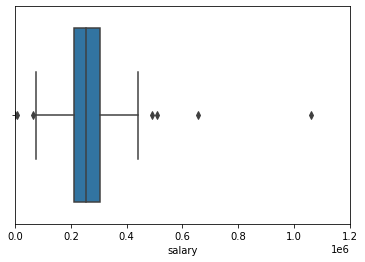

In [18]:
#A boxplot to see the salary distribution
sns.boxplot(df_t.salary)
plt.xlim(0, 1200000)

###### notice the outliers from $500,000

In [19]:
# check to see poi distribution before outlier removal
df_t.poi.value_counts()

False    127
True      16
Name: poi, dtype: int64

In [20]:
# removing outlier from $1,500,000 salary
df_t = df_t.iloc[(np.where(df_t["salary"] < 1500000))]


/Users/joshiverse/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='poi', ylabel='count'>

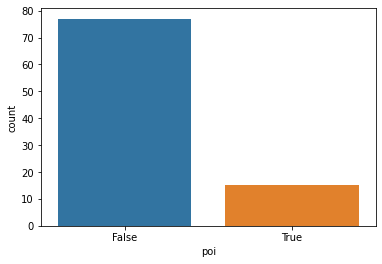

In [21]:
# check to see poi distribution after outlier removal
sns.countplot(df_t.poi)

In [22]:
df_t.poi.value_counts()

False    77
True     15
Name: poi, dtype: int64

In [23]:
df_t.dtypes

salary                       float64
to_messages                   object
deferral_payments             object
total_payments                object
loan_advances                 object
bonus                        float64
email_address                 object
restricted_stock_deferred     object
deferred_income               object
total_stock_value             object
expenses                      object
from_poi_to_this_person      float64
exercised_stock_options       object
from_messages                 object
other                         object
from_this_person_to_poi      float64
poi                           object
long_term_incentive           object
shared_receipt_with_poi       object
restricted_stock              object
director_fees                 object
dtype: object

In [24]:
d = df_t.replace([np.inf, -np.inf], np.nan)

In [25]:
d = df_t.fillna(0)

In [26]:
d.isnull().sum()

salary                       0
to_messages                  0
deferral_payments            0
total_payments               0
loan_advances                0
bonus                        0
email_address                0
restricted_stock_deferred    0
deferred_income              0
total_stock_value            0
expenses                     0
from_poi_to_this_person      0
exercised_stock_options      0
from_messages                0
other                        0
from_this_person_to_poi      0
poi                          0
long_term_incentive          0
shared_receipt_with_poi      0
restricted_stock             0
director_fees                0
dtype: int64

In [27]:
dt = df_t.copy()

In [28]:
df_t.fillna(0,inplace=True)

In [29]:
df_t.isnull().sum()

salary                       0
to_messages                  0
deferral_payments            0
total_payments               0
loan_advances                0
bonus                        0
email_address                0
restricted_stock_deferred    0
deferred_income              0
total_stock_value            0
expenses                     0
from_poi_to_this_person      0
exercised_stock_options      0
from_messages                0
other                        0
from_this_person_to_poi      0
poi                          0
long_term_incentive          0
shared_receipt_with_poi      0
restricted_stock             0
director_fees                0
dtype: int64

In [30]:
# convert features back into objects
df_t.salary = df_t.salary.astype(str)
df_t.bonus = df_t.bonus.astype(str)
df_t.from_poi_to_this_person  = df_t.from_poi_to_this_person .astype(str)
df_t.from_this_person_to_poi = df_t.from_this_person_to_poi.astype(str)

In [31]:
# transposing the dataframe back to its original shape
df = df_t.T

In [32]:
df.head(2)

,METTS MARK,BAXTER JOHN C,ELLIOTT STEVEN,HANNON KEVIN P,MORDAUNT KRISTINA M,MCMAHON JEFFREY,HAEDICKE MARK E,PIPER GREGORY F,HUMPHREY GENE E,BLACHMAN JEREMY M,...,BAY FRANKLIN R,KOENIG MARK E,IZZO LAWRENCE L,TILNEY ELIZABETH A,MARTIN AMANDA K,BUY RICHARD B,CAUSEY RICHARD A,TAYLOR MITCHELL S,DONAHUE JR JEFFREY M,GLISAN JR BEN F
salary,365788.0,267102.0,170941.0,243293.0,267093.0,370448.0,374125.0,197091.0,130724.0,248546.0,...,239671.0,309946.0,85274.0,247338.0,349487.0,330546.0,415189.0,265214.0,278601.0,274975.0
to_messages,807,NaN,NaN,1045,NaN,2355,4009,1238,128,2475,...,NaN,2374,496,460,1522,3523,1892,533,865,873


In [33]:
# converting the dataframe to the dictionary format to be read by featureFormat
df_dict = df.to_dict()

In [34]:
df_dict

{'METTS MARK': {'salary': '365788.0',
  'to_messages': 807,
  'deferral_payments': 'NaN',
  'total_payments': 1061827,
  'loan_advances': 'NaN',
  'bonus': '600000.0',
  'email_address': 'mark.metts@enron.com',
  'restricted_stock_deferred': 'NaN',
  'deferred_income': 'NaN',
  'total_stock_value': 585062,
  'expenses': 94299,
  'from_poi_to_this_person': '38.0',
  'exercised_stock_options': 'NaN',
  'from_messages': 29,
  'other': 1740,
  'from_this_person_to_poi': '1.0',
  'poi': False,
  'long_term_incentive': 'NaN',
  'shared_receipt_with_poi': 702,
  'restricted_stock': 585062,
  'director_fees': 'NaN'},
 'BAXTER JOHN C': {'salary': '267102.0',
  'to_messages': 'NaN',
  'deferral_payments': 1295738,
  'total_payments': 5634343,
  'loan_advances': 'NaN',
  'bonus': '1200000.0',
  'email_address': 'NaN',
  'restricted_stock_deferred': 'NaN',
  'deferred_income': -1386055,
  'total_stock_value': 10623258,
  'expenses': 11200,
  'from_poi_to_this_person': '0.0',
  'exercised_stock_opt

In [35]:
df_clean = df_dict

<hr/>

### Task 3: Extract Features and Labels

In [37]:
### Storing to my_dataset 
my_dataset = data_dict
# my_dataset = df

In [38]:
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

### Task 4: Try a varity of classifiers

##### Naive Bayes on data with outliers

In [40]:
# Trying a variety of classifiers.
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

In [41]:
# Example starting point. Try investigating other evaluation techniques!
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

In [44]:
from sklearn.metrics import accuracy_score

In [42]:
clf.fit(features_train,labels_train)

GaussianNB()

In [43]:
pred = clf.predict(features_test)

In [45]:
accuracy_score(labels_test, pred)

0.84375

<hr/>


#### Predictions with the ouliers removed from data

In [46]:
data_c = featureFormat(df_clean, features_list, sort_keys = True)
y, x = targetFeatureSplit(data_c)

In [47]:
clf2 = GaussianNB()

In [48]:
poi = 0
for key in df_clean.keys():
    if df_clean[key]['poi'] == True:
        poi+=1
    else:
        continue
print(poi)

15


In [49]:
x_train, x_test, y_train, y_test = \
    train_test_split(x, y, test_size=0.3, random_state=43)

In [50]:
np.all(np.isfinite(data_c))

True

In [51]:
np.any(np.isnan(data_c))

False

In [52]:
np.any(data_c.item == 0)

False

<hr/>

##### Guassian Naive Bayes Classifier


In [53]:
clf2.fit(x_train,y_train)

GaussianNB()

In [54]:
pred2 = clf2.predict(x_test)

In [55]:
accuracy_score(y_test, pred2)

0.7142857142857143

> The NB classifier's accuracy dropped with the removal of the existing outliers

<hr/>

##### Using Support Vector Classifier

In [56]:
from sklearn import svm

In [64]:
svc_clf = svm.SVC(C=1)

In [65]:
svc_clf.fit(x_train,y_train)

SVC(C=1)

In [66]:
pred = svc_clf.predict(x_test)

In [67]:
acc2 = accuracy_score(pred, y_test)

In [68]:
acc2

0.75

<hr/>

##### Logistic Regression

In [69]:
from sklearn.linear_model import LogisticRegression


log_reg = LogisticRegression()

In [70]:
log_reg.fit(x_train, y_train)

LogisticRegression()

In [71]:
pred_log = log_reg.predict(x_test)

accuracy_score(pred_log,y_test)

0.75

<hr/>